<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/LP_optimal_transport_entropic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Entropic Regularization of Optimal Transport**
============================================

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$
$\newcommand{\ones}{\mathbbm{1}}$

This notebook is a reduced version of the original numerical tour (from Gabriel Peyre - see his [website](https://www.numerical-tours.com/) for more detail). The notebook is here simplified for the purpose of the Large-scale Optimization course. We first load some needed packages.

In [ ]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl
import cvxpy as cp

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Problem: Transport Between Point Clouds
------------------------------
We are given two point clouds
(that do not necessarily have the same size), $X=(X_i)_{i=1}^{n}, Y=(Y_i)_{i=1}^{m}, $
where $X_i, Y_i \in \RR^2$.


The number of points in each cloud are $N=(n,m)$. Next we generate the point clouds.

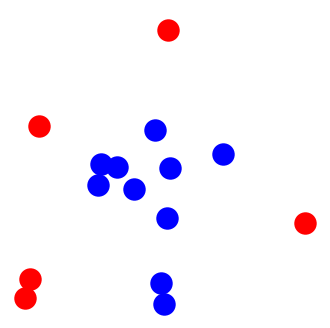

In [ ]:
# generate the point clouds
n = 10      # first cloud has n points
m = 5       # second cloud has m points
#
N = [n,m]
X = np.random.rand(2,N[0])-.5                                                   # generate n two-dim random vectors in the [-0.5,0.5] (choose random locations inside a square)
theta = 2*np.pi*np.random.rand(1,N[1])                                          # generate m random angles in [0,2*pi]
r = .8 + .2*np.random.rand(1,N[1])                                              # generate m random radii in [0.8, 1]
Y = np.vstack((np.cos(theta)*r,np.sin(theta)*r))                                # choose random locations for y inside an anulus



# define some functions
plotp = lambda x,col: plt.scatter(x[0,:], x[1,:], s=200,  c=col, linewidths=2)  # scatter plot (used below for the point clouds)
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*20, c=col, linewidths=2)      # scatter plot with links (used later)



#plot the random points
plt.figure(figsize=(4,4))
plotp(X, 'b')
plotp(Y, 'r')
plt.axis("off")
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

The optimal transport problem aims to compute a coupling $(x_{ij})$ that transports supply $s_i$ from point $i$ to meet the demand $d_j$ at point $j$ at minimum cost. Formally, this is given by:

\begin{align} \min &\sum_{ij} C_{ij}x_{ij}\\
\text{subject to} & \sum_j x_{ij} = s_i ~~~\forall i \\
& \sum_i x_{ij} = d_j ~~~\forall j
\end{align}
where, the cost matrix is $C_{ij} = \norm{X_i-Y_j}^2$. As an example, we will set $s, d$ to  have uniform supply/demand (ie equally split between the points), but in general the problem can be formulated for any such input vectors.

In [ ]:
# generate C, s, d
X2 = np.sum(X**2,0)         # sum of squares of X
Y2 = np.sum(Y**2,0)         # sum of squares of Y
C = np.tile(Y2,(N[0],1)) + np.tile(X2[:,np.newaxis],(1,N[1])) - 2*np.dot(np.transpose(X),Y)    # creates a matrix C with elements C_ij = X_i^2 + Y_j^2 - 2X_iY_j (squared Euclidean distance)
s = np.ones(N[0])/N[0]      # sets s_i = 1/n for all i
d = np.ones(N[1])/N[1]      # sets d_j = 1/m for all j


# Use below code to add random demands and supplies per node
#normalize = lambda a: a/np.sum(a)
#s = normalize(np.random.rand(N[0]))
#d = normalize(np.random.rand(N[1]))

LP solver approach
--------------------

First, we solve the Optimal Transport problem using the cvx-opt package (which runs the interior point method for LPs)

In [ ]:
# here we prepare the Linear program
x = cp.Variable((N[0],N[1]))                                      # define the optimization variables x
u = np.ones((N[1]))                                               # aux vector of 1s to provide column sum of x (x^T*1=s)
v = np.ones((N[0]))                                               # aux vector of 1s to provide row sum of x (x*1=d)
constraints = [0 <= x, x@u==s, x.T@v==d]                          # build the constraints
objective = cp.Minimize( cp.sum(cp.multiply(x,C)) )               # build the objective
prob = cp.Problem(objective, constraints)



# here we solve the Linear program
#%%timeit
result = prob.solve()
print(f"The total cost is: {result}")

The total cost is: 0.5165423188929568


An optimal coupling $x^*$ can be shown to be a sparse matrix with less than $n+m−1$  non zero entries. An element $x^*_{ij}\neq 0$ should be understood as a link between $X_i$ and $Y_j$ points that transports non-zero supply equal to  $x^*_{ij}$.

Let's check the number of non-zero entries. Beware that we are using an interior point method here, so that entries of $x^*$ are nevery exactly 0, hence we use an accuracy threshold.

In [ ]:
print(f"Number of non-zero elements of x*: {len(x.value[x.value>1e-4])} (where: n + m-1 = {N[0] + N[1]-1})")

Number of non-zero elements of x*: 10 (where: n + m-1 = 14)


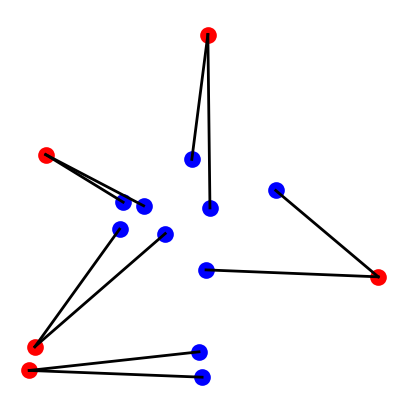

In [ ]:
# visualize the solution
I,J = np.nonzero(x.value>1e-2) # plot only solutions with more than 1e-3 value
plt.figure(figsize = (5,5))
plt.axis('off')
for k in range(len(I)): h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 2)
for i in range(len(s)): myplot(X[0,i], X[1,i], s[i]*len(s)*5, 'b')
for j in range(len(d)): myplot(Y[0,j], Y[1,j], d[j]*len(d)*5, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

Entropic Regularization of Optimal Transport
--------------------------------------------
We consider the following discrete regularized transport

\begin{align} \min &\sum_{ij} C_{ij}x_{ij}+\epsilon\sum_{ij}x_{ij}(\log x_{ij}-1)\\
\text{subject to} & \sum_j x_{ij} = s_i ~~~\forall i \\
& \sum_i x_{ij} = d_j ~~~\forall j
\end{align}


When $\epsilon=0$ one recovers the classical (discrete) optimal transport.
The idea of regularizing transport to allows for faster computation is
introduced in [Cuturi](#biblio).

Consider the kernel $\xi = e^{-C/\epsilon}$, i.e., let $\xi_{ij} = e^{-C_{ij}/\epsilon}$.

In [ ]:
epsilon = .01;            # Regularization strength: epsilon > 0
xi = np.exp(-C/epsilon)   # Gibbs Kernel xi

The regularized transportation problem can be re-written as a projection $$
\min_{x\in \mathcal{X}_s \cup \mathcal{X}_d}KL(x|\xi)$$ where KL(.) is the Kullback-Leibler divergence:$$
KL(x|\xi)\triangleq \sum_{ij}x_{ij}(\log(x_{ij}/\xi_{ij})−1)$$
therefore one way to solve the problem is by using the theorem of iterative projections on convex sets (e.g. see https://en.wikipedia.org/wiki/Projections_onto_convex_sets). This requires to perform the operations:
$$ \hat{x}^{k+1} \leftarrow \arg\min_{x\in \mathcal{X}_s}KL(x|x^k) $$
$$ x^{k+1} \leftarrow \arg\min_{x\in \mathcal{X}_d}KL(x|\hat{x}^{k+1}) $$
and $x^0 = \xi$.

However, next we present a even more scalable way of doing this.


Sinkhorn's Algorithm
-----------------------------------------------------------------------

Let $x_{\epsilon}^*$ be the optimal solution to the regularized optimal transport. Then, a fundamental remark is that the optimality condition (the stationarity of the Lagrangian) of the entropic regularized problem shows that
$$x_{\epsilon}^* = \text{diag}(a)\cdot \xi \cdot \text{diag}(b)$$


where $a,b$ are dual variables. In other words, for each $(i,j)$, we must have: $x_{\epsilon,ij}^*=a_i\xi_{ij}b_j$.

One thus needs to find two positive scaling vectors $a \in \RR_+^n$ and $b \in \RR_+^m$ such that the two following equality holds
$$x 1  = a \odot (\xi b)^{-1} = s
\qandq
x^\top 1  = b \odot (\xi^\top a)^{-1} = d.$$

Sinkhorn's algorithm alternate between the resolution of these two equations, and reads
$$a \longleftarrow \frac{s}{\xi b} \qandq b \longleftarrow \frac{d}{\xi^\top a}.$$
This algorithm was shown to converge to a solution of the entropic regularized problem by [Sinkhorn](#biblio).

In [ ]:
# Sinkhorn algorithm
def Sinkhorn(s, d, xi, accuracy):
  b = np.ones(N[1])
  residual = [] # vector to host the residuals
  s = s.flatten()
  d = d.flatten()
  res = 1 # initialize residual as 1
  while ( res > accuracy ):
    a = s / (xi @ b)
    b = d / (xi.T @ a)
    P = np.diag(a) @ xi @ np.diag(b)
    res = np.linalg.norm(P.sum(axis=1) - s) # compute residual as the norm of the column sum of P minus s
    residual.append(res) # store
  return a, b, residual

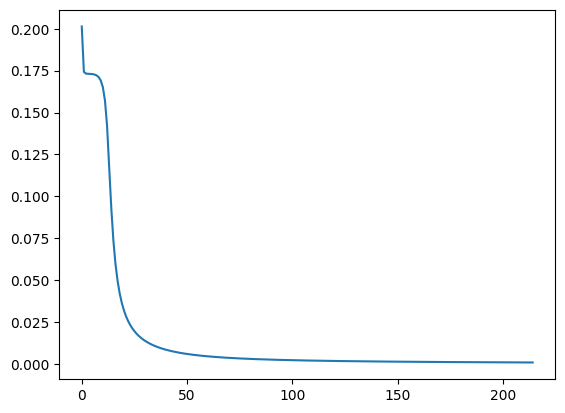

In [ ]:
# run the algorithm with a target tolerance for the residual
accuracy = 0.001
a, b, residual = Sinkhorn(s, d, xi, accuracy)
xe = np.diag(a) @ xi @ np.diag(b)
plt.plot(residual)

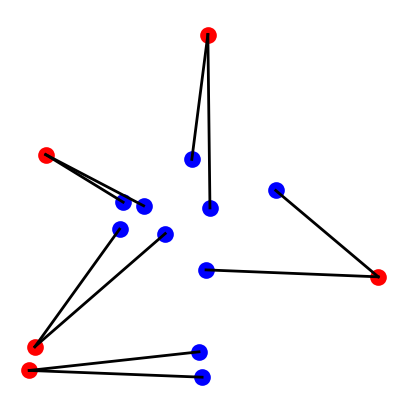

The total cost is: 0.5168246455238237


In [ ]:
# display the solution
I,J = np.nonzero(xe>1e-2) # do not plot connections with very small allocation
plt.figure(figsize = (5,5))
plt.axis('off')
for k in range(len(I)): h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 2)
for i in range(len(s)): myplot(X[0,i], X[1,i], s[i]*len(s)*5, 'b')
for j in range(len(d)): myplot(Y[0,j], Y[1,j], d[j]*len(d)*5, 'r')
plt.xlim(np.min(Y[0,:])-.1,np.max(Y[0,:])+.1)
plt.ylim(np.min(Y[1,:])-.1,np.max(Y[1,:])+.1)
plt.show()

print(f"The total cost is: {np.sum(np.multiply(xe,C))}")